In [58]:
import os
import gc
import math
import sys
import importlib.util
from pathlib import Path

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil

# Dynamic Device Selection
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f'Using CUDA: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('Using MPS')
else:
    DEVICE = torch.device('cpu')
    print('Using CPU')


Using MPS


Original Data

In [59]:
DEPTH_SCALE = 256.0  # t?pico KITTI

def read_depth_png(path):
    d = cv2.imread(str(path), cv2.IMREAD_UNCHANGED).astype(np.float32)
    return d / DEPTH_SCALE

def apply_top_crop(arr, top_crop):
    # arr: np.float32 (H, W)
    return arr[top_crop:, :]

class KittiDepthValCropped(Dataset):
    def __init__(self, root, top_crop=100, scale=0.3):
        self.root = Path(root)
        base = self.root / "data" / "data_depth_selection" / "depth_selection" / "val_selection_cropped"
        self.sparse = sorted((base / "velodyne_raw").glob("*.png"))
        self.gt = sorted((base / "groundtruth_depth").glob("*.png"))
        self.top_crop = top_crop
        self.scale = scale

    def __len__(self):
        return len(self.sparse)

    def __getitem__(self, i):
        d_sparse = read_depth_png(self.sparse[i])   # metros (seg?n tu conv.)
        d_gt = read_depth_png(self.gt[i])           # metros (seg?n tu conv.)

        d_sparse = cv2.resize(apply_top_crop(d_sparse, self.top_crop), None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)
        d_gt = cv2.resize(apply_top_crop(d_gt, self.top_crop), None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        mask = (d_gt > 0).astype(np.float32)

        d_sparse = torch.from_numpy(d_sparse).unsqueeze(0)   # (1,H,W)
        d_gt = torch.from_numpy(d_gt).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return {"sparse": d_sparse, "gt": d_gt, "mask": mask}


class KittiDepthData(Dataset):
    def __init__(self, root, subset="train", top_crop=100, scale=0.3):
        self.root = Path(root)
        self.subset = subset
        self.top_crop = top_crop
        self.scale = scale

        base_gt = self.root / "data" / "data_depth_annotated" / subset
        base_sparse = self.root / "data" / "data_depth_velodyne" / subset

        assert base_gt.exists(), f"No existe {base_gt}"
        assert base_sparse.exists(), f"No existe {base_sparse}"

        self.samples = []
        for seq_dir in sorted(p for p in base_gt.iterdir() if p.is_dir()):
            gt_dir = seq_dir / "proj_depth" / "groundtruth" / 'image_02'
            vel_dir = base_sparse / seq_dir.name / "proj_depth" / "velodyne_raw" / 'image_02'

            for p in sorted(gt_dir.glob("*.png")):
                stem = p.stem
                p_vel = vel_dir / f"{stem}.png"
                if p_vel.exists():
                    self.samples.append((p_vel, p))
                else:
                    print(f"Warning: no existe {p_vel}, se ignora este ejemplo.")

        print(f"Encontradas {len(self.samples)} parejas sparse/gt en {subset}.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        d_sparse = read_depth_png(self.samples[i][0])   # metros (seg?n tu conv.)
        d_gt = read_depth_png(self.samples[i][1])       # metros (seg?n tu conv.)

        d_sparse = cv2.resize(apply_top_crop(d_sparse, self.top_crop), None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)
        d_gt = cv2.resize(apply_top_crop(d_gt, self.top_crop), None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        mask = (d_gt > 0).astype(np.float32)

        d_sparse = torch.from_numpy(d_sparse).unsqueeze(0)   # (1,H,W)
        d_gt = torch.from_numpy(d_gt).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)

        return {"sparse": d_sparse, "gt": d_gt, "mask": mask}


def kitti_metrics(pred_m, gt_m, mask):
    # pred_m, gt_m, mask: (N,1,H,W)
    eps = 1e-6
    m = (mask > 0).float()
    num = m.sum().clamp_min(1.0)

    diff = (pred_m - gt_m) * m
    rmse_mm = torch.sqrt((diff**2).sum() / num) * 1000.0
    mae_mm  = (diff.abs().sum() / num) * 1000.0

    inv_pred = 1.0 / (pred_m.clamp_min(eps))
    inv_gt   = 1.0 / (gt_m.clamp_min(eps))
    inv_diff = (inv_pred - inv_gt) * m
    irmse_per_km = torch.sqrt((inv_diff**2).sum() / num) * 1000.0
    imae_per_km  = (inv_diff.abs().sum() / num) * 1000.0
    return dict(RMSE_mm=rmse_mm.item(),
                MAE_mm=mae_mm.item(),
                iRMSE_1_per_km=irmse_per_km.item(),
                iMAE_1_per_km=imae_per_km.item())


def evaluate_identity_sparse(loader, device=DEVICE):
    rmse = mae = irmse = imae = 0.0
    total = 0
    for batch in loader:
        sparse = batch["sparse"].to(device).float()
        gt     = batch["gt"].to(device).float()
        mask   = batch["mask"].to(device).float()

        pred = sparse  # baseline tonto: usar la nube sparse como pred

        mets = kitti_metrics(pred, gt, mask)
        rmse += mets["RMSE_mm"]; mae += mets["MAE_mm"]
        irmse += mets["iRMSE_1_per_km"]; imae += mets["iMAE_1_per_km"]
        total += 1
    return {
        "RMSE_mm": rmse/max(1, total), "MAE_mm": mae/max(1, total),
        "iRMSE_1_per_km": irmse/max(1, total), "iMAE_1_per_km": imae/max(1, total)
    }


Load Datasets


In [60]:
def build_datasets(data_root, top_crop=100, scale=0.3, subset_size=None, seed=42, use_cropped_val=False):
    ds_train = KittiDepthData(data_root, top_crop=top_crop, scale=scale)
    if use_cropped_val:
        ds_val = KittiDepthValCropped(data_root, top_crop=top_crop, scale=scale)
    else:
        ds_val = KittiDepthData(data_root, subset="val", top_crop=top_crop, scale=scale)

    if subset_size is not None:
        g = torch.Generator().manual_seed(seed)  # reproducible
        n = min(subset_size, len(ds_train))
        idx = torch.randperm(len(ds_train), generator=g)[:n].tolist()
        ds_train = Subset(ds_train, idx)
    return ds_train, ds_val

def build_loaders(ds_train, ds_val, batch_size=1, num_workers=4, prefetch_factor=1, shuffle_train=False, pin_memory=False, persistent_workers=True):
    cv2.setNumThreads(0)

    # MacOS stability fix: force num_workers=0 if using MPS unless explicitly handled
    try:
        if torch.backends.mps.is_available() and num_workers > 0:
            print(f"[INFO] MacOS MPS detected: Forcing num_workers=0 to avoid multiprocessing crashes.")
            num_workers = 0
    except:
        pass

    loader_kwargs = {
        "batch_size": batch_size,
        "num_workers": num_workers,
        "pin_memory": pin_memory,
    }
    if num_workers > 0:
        loader_kwargs.update({
            "persistent_workers": persistent_workers,
            "prefetch_factor": prefetch_factor,
        })
    else:
        loader_kwargs["persistent_workers"] = False

    loader_train = DataLoader(ds_train, shuffle=shuffle_train, **loader_kwargs)
    loader_val = DataLoader(ds_val, shuffle=False, **loader_kwargs)
    return loader_train, loader_val


Cached Data

In [61]:
def precompute_data_cache(
    root,
    top_crop=100,
    scale=0.1,
    cache_tag=None,
    train_subset_idx=None,
    batch_size=1,
    num_workers=0,
    shuffle_train=True,
    run_identity=False,
):
    """
    Preprocesa PNGs (top-crop + resize) a .npy y devuelve datasets y loaders cacheados listos.
    """
    root = Path(root)
    cache_tag = cache_tag or f"tc{top_crop}_s{scale}"

    def get_data_root(r: Path) -> Path:
        return (Path(r) / "data").resolve()

    def get_cache_root(r: Path, tag: str) -> Path:
        return get_data_root(r) / "_cache" / tag

    def to_cache_path(r: Path, png_path: Path, tag: str) -> Path:
        data_root = get_data_root(r)
        rel = png_path.resolve().relative_to(data_root)
        npy = get_cache_root(r, tag) / rel
        return npy.with_suffix(".npy")

    def ensure_cached_depth(png_path: Path, r: Path, top: int, sc: float, tag: str) -> Path:
        npy_path = to_cache_path(r, png_path, tag)
        if not npy_path.exists():
            d = read_depth_png(png_path)
            d = apply_top_crop(d, top)
            d = cv2.resize(d, None, fx=sc, fy=sc, interpolation=cv2.INTER_NEAREST)
            npy_path.parent.mkdir(parents=True, exist_ok=True)
            np.save(npy_path, d.astype(np.float32))
        return npy_path

    def precompute_train(ds_train: "KittiDepthData", r: Path, top=top_crop, sc=scale, tag=cache_tag):
        iterator = train_subset_idx if train_subset_idx is not None else range(len(ds_train))
        print(f"Precomputing cache for train ({len(ds_train)} samples) -> {get_cache_root(r, tag)}")
        for i in tqdm(iterator, desc="cache train"):
            sp_png, gt_png = ds_train.samples[i]
            ensure_cached_depth(sp_png, r, top, sc, tag)
            ensure_cached_depth(gt_png,  r, top, sc, tag)

    def precompute_val(ds_val: "KittiDepthValCropped", r: Path, top=top_crop, sc=scale, tag=cache_tag):
        print(f"Precomputing cache for val ({len(ds_val)} samples) -> {get_cache_root(r, tag)}")
        for sp_png, gt_png in tqdm(zip(ds_val.sparse, ds_val.gt), total=len(ds_val), desc="cache val"):
            ensure_cached_depth(sp_png, r, top, sc, tag)
            ensure_cached_depth(gt_png,  r, top, sc, tag)

    class KittiDepthDataCached(Dataset):
        """Version cached del DATASET train/val grande: carga .npy (preprocesados) en lugar de PNG."""
        def __init__(self, root, subset="train", cache_tag=cache_tag):
            self.root = Path(root)
            self.cache_tag = cache_tag

            base_gt = self.root / "data" / "data_depth_annotated" / subset
            base_sp = self.root / "data" / "data_depth_velodyne"  / subset
            assert base_gt.exists() and base_sp.exists()

            self.samples = []
            for seq_dir in sorted(p for p in base_gt.iterdir() if p.is_dir()):
                gt_dir = seq_dir / "proj_depth" / "groundtruth" / "image_02"
                sp_dir = base_sp / seq_dir.name / "proj_depth" / "velodyne_raw" / "image_02"
                if not gt_dir.exists() or not sp_dir.exists():
                    continue
                for gt_png in sorted(gt_dir.glob("*.png")):
                    sp_png = sp_dir / gt_png.name
                    if sp_png.exists():
                        self.samples.append((sp_png, gt_png))
            assert len(self.samples) > 0, "No samples found."

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, i):
            sp_png, gt_png = self.samples[i]
            sp_npy = ensure_cached_depth(sp_png, self.root, top_crop, scale, self.cache_tag)
            gt_npy = ensure_cached_depth(gt_png, self.root, top_crop, scale, self.cache_tag)

            d_sp = np.array(np.load(sp_npy, mmap_mode="r"), copy=True)
            d_gt = np.array(np.load(gt_npy, mmap_mode="r"), copy=True)
            mask = (d_gt > 0).astype(np.float32)

            return {
                "sparse": torch.from_numpy(d_sp).unsqueeze(0),
                "gt":     torch.from_numpy(d_gt).unsqueeze(0),
                "mask":   torch.from_numpy(mask).unsqueeze(0),
            }

    class KittiDepthValCroppedCached(Dataset):
        """Version cached del val_selection_cropped: carga .npy en lugar de PNG."""
        def __init__(self, root, cache_tag=cache_tag):
            self.root = Path(root)
            self.cache_tag = cache_tag
            base = self.root / "data" / "data_depth_selection" / "depth_selection" / "val_selection_cropped"
            self.sparse = sorted((base / "velodyne_raw").glob("*.png"))
            self.gt     = sorted((base / "groundtruth_depth").glob("*.png"))
            assert len(self.sparse) == len(self.gt) > 0

        def __len__(self):
            return len(self.sparse)

        def __getitem__(self, i):
            sp_png = self.sparse[i]
            gt_png = self.gt[i]
            sp_npy = ensure_cached_depth(sp_png, self.root, top_crop, scale, self.cache_tag)
            gt_npy = ensure_cached_depth(gt_png, self.root, top_crop, scale, self.cache_tag)

            d_sp = np.array(np.load(sp_npy), copy=True)
            d_gt = np.array(np.load(gt_npy), copy=True)
            mask = (d_gt > 0).astype(np.float32)

            return {
                "sparse": torch.from_numpy(d_sp).unsqueeze(0),
                "gt":     torch.from_numpy(d_gt).unsqueeze(0),
                "mask":   torch.from_numpy(mask).unsqueeze(0),
            }

    ds_train = KittiDepthData(root, top_crop=top_crop, scale=scale)
    ds_val = KittiDepthValCropped(root, top_crop=top_crop, scale=scale)

    precompute_train(ds_train, root, top_crop, scale, cache_tag)
    precompute_val(ds_val, root, top_crop, scale, cache_tag)

    ds_train_cached = KittiDepthDataCached(root, subset="train", cache_tag=cache_tag)
    if train_subset_idx is not None:
        ds_train_cached = Subset(ds_train_cached, train_subset_idx)
    ds_val_cached = KittiDepthValCroppedCached(root, cache_tag=cache_tag)

    loader_train, loader_val = build_loaders(
        ds_train_cached,
        ds_val_cached,
        batch_size=batch_size,
        num_workers=num_workers,
        prefetch_factor=1,
        shuffle_train=shuffle_train,
        pin_memory=False,
        persistent_workers=num_workers > 0,
    )

    print("train:", len(ds_train_cached), "| val:", len(ds_val_cached))
    print("Sample shape:", next(iter(loader_train))["sparse"].shape)

    baseline = evaluate_identity_sparse(loader_val) if run_identity else None
    if baseline:
        print("Identity baseline (cached val):", baseline)

    return {
        "cache_tag": cache_tag,
        "ds_train": ds_train_cached,
        "ds_val": ds_val_cached,
        "loader_train": loader_train,
        "loader_val": loader_val,
        "baseline": baseline,
    }


RAM USED

In [62]:
def ram_usage(loader_train, loader_val, n_warmup=2):

    def measure_cpu_ram_one_batch(loader, description="loader"):
        import psutil # Ensure available
        """
        Mide aproximadamente cu?nta RAM adicional se usa al cargar UN batch
        desde 'loader'.
        """
        process = psutil.Process(os.getpid())

        it = iter(loader)
        for _ in range(n_warmup):
            try:
                _ = next(it)
            except StopIteration:
                print(f"[WARN] Loader {description} agotado durante warmup.")
                return None, None

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()

        mem_before = process.memory_info().rss  # bytes
        batch = next(it)
        mem_after = process.memory_info().rss  # bytes
        used_mb = (mem_after - mem_before) / (1024 ** 2)

        print(f"[CPU] ~RAM extra para un batch de {description}: {used_mb:.2f} MB")
        return used_mb, batch

    cpu_mb, example_batch = measure_cpu_ram_one_batch(
        loader_train,
        description="train"
    )

    cpu_mb_val, example_batch_val = measure_cpu_ram_one_batch(
        loader_val,
        description="val"
    )

    return {
        "train_mb": cpu_mb,
        "val_mb": cpu_mb_val,
        "train_batch": example_batch,
        "val_batch": example_batch_val,
    }


VRAM USED

In [63]:
def move_batch_to_device(batch, device):
    batch_gpu = {}
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch_gpu[k] = v.to(device, non_blocking=True)
        else:
            batch_gpu[k] = v
    return batch_gpu


def vram_usage(example_batch, example_batch_val=None, model=None, device=None):

    dev = device or DEVICE
    print(f"Checking memory usage for device: {dev}")

    def prepare_model_input(batch_gpu):
        if "mask" in batch_gpu:
            return torch.cat([batch_gpu["sparse"], batch_gpu["mask"]], dim=1)
        return batch_gpu["sparse"]

    def measure_gpu_for_batch(batch, description="batch"):
        if dev.type == "cpu":
            return 0.0

        if dev.type == "cuda":
            if not torch.cuda.is_available():
                return 0.0
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        elif dev.type == "mps":
            if not torch.backends.mps.is_available():
                return 0.0
            torch.mps.empty_cache()

        batch_gpu = move_batch_to_device(batch, dev)

        model_to_use = model
        if model_to_use is not None:
            model_to_use = model_to_use.to(dev)
            model_to_use.eval()
            with torch.no_grad():
                _ = model_to_use(prepare_model_input(batch_gpu))

        used_mb = 0.0
        if dev.type == "cuda":
            torch.cuda.synchronize()
            used_mb = torch.cuda.max_memory_allocated() / (1024 ** 2)
            print(f"[GPU] VRAM used for {description}: {used_mb:.2f} MB")
        elif dev.type == "mps":
            # Try multiple methods for MPS memory
            try:
                used_mb = torch.mps.current_allocated_memory() / (1024 ** 2)
                print(f"[MPS] VRAM used for {description}: {used_mb:.2f} MB")
            except AttributeError:
                try:
                    used_mb = torch.mps.driver_allocated_memory() / (1024 ** 2)
                    print(f"[MPS] Driver RAM used for {description}: {used_mb:.2f} MB")
                except AttributeError:
                    print(f"[MPS] Memory tracking not supported in this PyTorch version.")
            except Exception as e:
                print(f"[MPS] Error checking memory: {e}")

        return used_mb

    return {
        "train_mb": measure_gpu_for_batch(
            example_batch,
            description="train (only batch)" if model is None else "train (batch+model)"
        ),
        "val_mb": measure_gpu_for_batch(
            example_batch_val,
            description="val (only batch)" if model is None else "val (batch+model)"
        ) if example_batch_val is not None else None,
    }


Model

In [64]:
import os
import sys
import importlib.util
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# ------------------------------------------------------------------
# 1) Setup ResNet (SMP U-Net)
# ------------------------------------------------------------------
def setup_resnet(device=DEVICE, steps_per_epoch=1, epochs=100):

    if device.type == 'cuda':
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    model = smp.Unet(encoder_name="resnet50",
                    encoder_weights="imagenet",
                    in_channels=2, classes=1, decoder_channels=(256,128,64,32,16)).to(device)
    model = model.to(memory_format=torch.channels_last)
    print(f"Modelo con {sum(p.numel() for p in model.parameters() if p.requires_grad)} parametros entrenables.")

    # GradScaler support
    scaler_device = 'cuda' if device.type == 'cuda' else 'cpu'
    scaler_enabled = (device.type == 'cuda')
    scaler = torch.amp.GradScaler(scaler_device, enabled=scaler_enabled)

    def set_requires_grad(module, flag: bool):
        for p in module.parameters():
            p.requires_grad = flag

    # Congela early encoder
    set_requires_grad(model.encoder.conv1,  False)
    set_requires_grad(model.encoder.bn1,    False)
    set_requires_grad(model.encoder.layer1, False)
    set_requires_grad(model.encoder.layer2, False)
    set_requires_grad(model.encoder.layer3, False)

    # Deja entrenable late encoder + decoder + head
    set_requires_grad(model.encoder.layer4, False)
    set_requires_grad(model.decoder, True)
    set_requires_grad(model.segmentation_head, True)

    def freeze_bn_stats(m):
        if isinstance(m, nn.BatchNorm2d):
            m.eval()

    model.apply(freeze_bn_stats)

    def param_groups_no_wd(model, wd=1e-4, lr_decoder=1e-3, lr_encoder=5e-4):
        decay, nodecay = [], []
        def add(module, lr):
            d, nd = [], []
            for n,p in module.named_parameters():
                if not p.requires_grad:
                    continue
                if p.ndim == 1 or n.endswith(".bias"):
                    nd.append(p)   # no WD en bias / norm
                else:
                    d.append(p)
            if d:  decay.append({"params": d,  "weight_decay": wd, "lr": lr})
            if nd: nodecay.append({"params": nd, "weight_decay": 0.0, "lr": lr})

        # late encoder (mas conservador)
        add(model.encoder.layer3, lr_encoder)
        add(model.encoder.layer4, lr_encoder)

        # decoder + head (pueden ir mas alto)
        add(model.decoder, lr_decoder)
        add(model.segmentation_head, lr_decoder)
        return decay + nodecay

    optimizer = torch.optim.AdamW(
        param_groups_no_wd(model, wd=1e-4, lr_decoder=1e-3, lr_encoder=5e-4),
        # lr se ignora por grupo; usa el de cada dict
        betas=(0.9, 0.999), eps=1e-8
    )

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[g.get("lr", 1e-3) for g in optimizer.param_groups],  # por grupo
        epochs=epochs,
        steps_per_epoch=max(1, steps_per_epoch),
        pct_start=0.3, div_factor=10.0, final_div_factor=1000.0,
        anneal_strategy="cos", cycle_momentum=False
    )

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,}")

    return model, optimizer, scheduler, scaler, epochs

# ------------------------------------------------------------------
# 2) Setup PNCNN (Sparsity Invariant CNN)
# ------------------------------------------------------------------
class SparsityInvariantConv(nn.Module):
    """Sparsity-invariant conv per Eldesokey et al. (CVPR 2020)."""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bias = nn.Parameter(torch.zeros(out_ch))

    def forward(self, x, mask):
        # x, mask: (B, C, H, W)
        eps = 1e-6
        weighted = F.conv2d(
            x * mask,
            self.conv.weight,
            bias=None,
            stride=self.conv.stride,
            padding=self.conv.padding,
            dilation=self.conv.dilation,
        )
        mask_sum = F.conv2d(
            mask,
            torch.ones_like(self.conv.weight),
            bias=None,
            stride=self.conv.stride,
            padding=self.conv.padding,
            dilation=self.conv.dilation,
        )
        denom = mask_sum.clamp_min(eps)
        out = weighted / denom
        out = out + self.bias.view(1, -1, 1, 1)
        valid = (mask_sum > 0).float()
        out = out * valid
        return out, valid


class SConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, activation=True):
        super().__init__()
        self.sconv = SparsityInvariantConv(in_ch, out_ch, kernel_size, stride, padding)
        self.act = nn.ReLU(inplace=True) if activation else nn.Identity()

    def forward(self, x, mask):
        x, mask = self.sconv(x, mask)
        x = self.act(x)
        return x, mask


class SparsityInvariantCNN(nn.Module):
    """Pequena red con convoluciones sparsity-invariant (paper CVPR20)."""
    def __init__(self, base_channels=32):
        super().__init__()
        self.block1 = SConvBlock(1, base_channels)
        self.block2 = SConvBlock(base_channels, base_channels)
        self.block3 = SConvBlock(base_channels, base_channels * 2)
        self.block4 = SConvBlock(base_channels * 2, base_channels * 2)
        self.head = SparsityInvariantConv(base_channels * 2, 1)

    def forward(self, x):
        # x: (B,2,H,W) with [sparse, mask]
        sparse = x[:, :1]
        mask = x[:, 1:2]
        mask = (mask > 0).float()

        h, m = self.block1(sparse, mask)
        h, m = self.block2(h, m)
        h, m = self.block3(h, m)
        h, m = self.block4(h, m)
        out, _ = self.head(h, m)
        return out


def setup_sparsity_invariant_CNN(device=DEVICE, steps_per_epoch=1, epochs=100, base_channels=32, lr=1e-3, pretrained_path=None):
    """Configura modelo sparsity-invariant inspirado en Eldesokey et al. (CVPR'20).
    Usa pesos preentrenados si se pasa pretrained_path (ruta a .pth/.pt).
    """
    if device.type == 'cuda':
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    model = SparsityInvariantCNN(base_channels=base_channels).to(device)
    model = model.to(memory_format=torch.channels_last)

    if pretrained_path:
        if os.path.isfile(pretrained_path):
            ckpt = torch.load(pretrained_path, map_location=device)
            state = ckpt.get("state_dict", ckpt)
            missing, unexpected = model.load_state_dict(state, strict=False)
            print(f"Cargados pesos desde {pretrained_path}. Missing: {missing}, Unexpected: {unexpected}")
        else:
            print(f"[WARN] Pretrained path {pretrained_path} not found. Starting from scratch.")

    print(f"Sparsity-invariant CNN con {sum(p.numel() for p in model.parameters() if p.requires_grad)} parametros entrenables.")

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    scaler_device = 'cuda' if device.type == 'cuda' else 'cpu'
    scaler_enabled = (device.type == 'cuda')
    scaler = torch.amp.GradScaler(scaler_device, enabled=scaler_enabled)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=max(1, steps_per_epoch),
        pct_start=0.3, div_factor=10.0, final_div_factor=1000.0,
        anneal_strategy="cos", cycle_momentum=False
    )

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total     = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable:,} / {total:,}")

    return model, optimizer, scheduler, scaler, epochs

# ------------------------------------------------------------------
# Utilidades de modelo compartidas
# ------------------------------------------------------------------
def get_depth_prediction(output):
    """Extrae el canal de profundidad de la salida del modelo."""
    if isinstance(output, (list, tuple)):
        if len(output) == 0:
            raise ValueError("La salida del modelo es vacia.")
        output = output[0]
    if isinstance(output, dict):
        for key in ("pred", "depth", "out", "output"):
            if key in output:
                output = output[key]
                break
    if torch.is_tensor(output):
        if output.ndim >= 4 and output.shape[1] > 1:
            return output[:, :1]
        return output
    raise TypeError(f"Tipo de salida no soportado: {type(output)}")


def load_pncnn_model(device=DEVICE, checkpoint_path=Path("pncnn/workspace/kitti/pncnn/model_best.pth.tar")):
    """Carga la implementacion oficial de pNCNN junto a sus pesos preentrenados."""
    pncnn_root = Path("pncnn").resolve()
    exp_dir = pncnn_root / "workspace" / "kitti" / "pncnn"
    for p in (pncnn_root, exp_dir):
        p_str = str(p)
        if p_str not in sys.path:
            sys.path.append(p_str)


        # Torch 2.x compatibility: robust int handling in _reverse_repeat_tuple
    from torch.nn.modules import utils as nn_utils
    if not getattr(nn_utils, '_pncnn_int_padding_patch', False):
        _orig_rrt = nn_utils._reverse_repeat_tuple
        def _rrt_safe(t, n):
            if isinstance(t, int):
                return tuple([t] * n)
            try:
                return _orig_rrt(t, n)
            except TypeError:
                return tuple([t] * n)
        nn_utils._reverse_repeat_tuple = _rrt_safe
        nn_utils._pncnn_int_padding_patch = True

    # Torch 2.x compatibility: guard _reverse_repeat_tuple for int padding
    from torch.nn.modules import utils as nn_utils, conv as nn_conv
    if not getattr(nn_utils, "_pncnn_int_padding_patch", False):
        _orig_rrt = nn_utils._reverse_repeat_tuple
        def _rrt_safe(t, n):
            if isinstance(t, int):
                return tuple([t] * n)
            try:
                return _orig_rrt(t, n)
            except TypeError:
                return tuple([t] * n)
        nn_utils._reverse_repeat_tuple = _rrt_safe
        nn_conv._reverse_repeat_tuple = _rrt_safe
        nn_utils._pncnn_int_padding_patch = True

    import importlib
    importlib.invalidate_caches()
    for mod in ("common.nconv", "common.unet"):
        if mod in sys.modules:
            importlib.reload(sys.modules[mod])

    network_path = exp_dir / "network.py"

    if not network_path.exists():
        raise FileNotFoundError(f"No se encontro network.py en {network_path}")

    spec = importlib.util.spec_from_file_location("pncnn_network", network_path)
    pncnn_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pncnn_module)

    model = pncnn_module.CNN().to(device)
    model = model.to(memory_format=torch.channels_last)

    ckpt_path = Path(checkpoint_path)
    if ckpt_path.exists():
        # Torch 2.6+: allow loading pickled argparse.Namespace in checkpoint
        import argparse
        try:
            torch.serialization.add_safe_globals([argparse.Namespace])
        except Exception:
            pass
        try:
            ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
        except TypeError:
            # weights_only not available in older versions
            ckpt = torch.load(ckpt_path, map_location=device)
        ckpt_model = None
        if isinstance(ckpt, dict) and isinstance(ckpt.get("model"), torch.nn.Module):
            ckpt_model = ckpt["model"]
        elif isinstance(ckpt, torch.nn.Module):
            ckpt_model = ckpt

        if ckpt_model is not None:
            model = ckpt_model.to(device)
            model = model.to(memory_format=torch.channels_last)
            print(f"Cargado modelo completo desde {ckpt_path}")
        else:
            state_dict = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
            missing, unexpected = model.load_state_dict(state_dict, strict=False)
            print(f"Cargados pesos desde {ckpt_path}. Missing: {missing}, Unexpected: {unexpected}")
    else:
        print(f"[WARN] No se encontro el checkpoint {ckpt_path}, usando pesos aleatorios.")

    model.eval()
    return model


In [65]:
def masked_l1(pred, gt, mask):
    m = (mask > 0).float()
    denom = m.sum().clamp_min(1.0)
    return ((pred - gt).abs() * m).sum() / denom

def train_one_epoch(model, loader, optimizer, scaler, device=DEVICE, scheduler=None):
    model.train()
    running = 0.0
    pbar = tqdm(loader, desc="train", leave=False)
    for i, batch in enumerate(pbar):
        sparse = batch["sparse"].to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        mask   = batch["mask"].to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        gt     = batch["gt"].to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        x = torch.cat([sparse, mask], dim=1)         # (B,2,H,W)

        optimizer.zero_grad(set_to_none=True)
        
        use_autocast = (device.type == 'cuda')
        
        with torch.amp.autocast('cuda', enabled=use_autocast):
            pred = get_depth_prediction(model(x))
            loss = masked_l1(pred, gt, mask)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

        running += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    return running / max(1, len(loader))

@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    model.eval()
    agg = {"RMSE_mm":0, "MAE_mm":0, "iRMSE_1_per_km":0, "iMAE_1_per_km":0}
    n = 0
    for batch in tqdm(loader, desc="val", leave=False):
        sparse = batch["sparse"].to(device).float()
        gt     = batch["gt"].to(device).float()
        mask   = batch["mask"].to(device).float()
        x = torch.cat([sparse, mask], dim=1)
        pred = get_depth_prediction(model(x))
        m = kitti_metrics(pred, gt, mask)
        for k in agg: agg[k] += m[k]
        n += 1
    for k in agg: agg[k] /= max(1, n)
    return agg


Training

In [66]:
def train_model(model, loader_train, loader_val, optimizer, scheduler, scaler, epochs, ckpt_path="ckpts/best_irmse_res50.pt", device=DEVICE):
    best_irmse = float("inf")
    os.makedirs(Path(ckpt_path).parent, exist_ok=True)
    history = []

    for epoch in range(epochs):
        tr_loss = train_one_epoch(model, loader_train, optimizer, scaler, device=device, scheduler=scheduler)
        val_m = evaluate(model, loader_val, device=device)
        history.append({"epoch": epoch+1, "train_l1": tr_loss, **val_m})

        print(f"Epoch {epoch+1:02d}/{epochs} | "
            f"train L1: {tr_loss:.4f} | "
            f"val iRMSE: {val_m['iRMSE_1_per_km']:.3f} 1/km | "
            f"RMSE: {val_m['RMSE_mm']:.1f} mm")

        # guarda el mejor seg?n iRMSE (m?s bajo es mejor)
        if val_m["iRMSE_1_per_km"] < best_irmse:
            best_irmse = val_m["iRMSE_1_per_km"]
            torch.save({
                "epoch": epoch+1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "val": val_m
            }, ckpt_path)
            print(f"  ? Guardado {ckpt_path} (iRMSE {best_irmse:.3f} 1/km)")
    return history



def finetune_pncnn_last_two_layers(model, loader_train, loader_val, device=DEVICE, epochs=20, lr=5e-5, weight_decay=1e-4, ckpt_path="ckpts/pncnn_last2_finetune.pt"):
    """Reentrena solo las dos ultimas capas top-level del pnCNN cargado."""
    # Congela todo
    for p in model.parameters():
        p.requires_grad = False

    children = list(model.named_children())
    last_two = children[-1:] if len(children) >= 2 else children
    for name, module in last_two:
        for p in module.parameters():
            p.requires_grad = True

    model = model.to(device)
    model = model.to(memory_format=torch.channels_last)

    params = [p for p in model.parameters() if p.requires_grad]
    if not params:
        raise RuntimeError("No hay parametros entrenables despues de congelar capas.")

    print(f"Finetune pnCNN: entrenando solo {len(last_two)} capas ({[n for n,_ in last_two]}), lr={lr}")
    trainable = sum(p.numel() for p in params)
    print(f"Parametros entrenables: {trainable:,}")

    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    scaler_device = 'cuda' if device.type == 'cuda' else 'cpu'
    scaler = torch.amp.GradScaler(scaler_device, enabled=(device.type == 'cuda'))

    history = train_model(
        model,
        loader_train,
        loader_val,
        optimizer,
        scheduler=None,
        scaler=scaler,
        epochs=epochs,
        ckpt_path=ckpt_path,
        device=device,
    )
    return history


Example

In [67]:
DATA_ROOT = Path("")

# 1) Datasets y dataloaders (sin cache)
# ds_train, ds_val = build_datasets(DATA_ROOT, top_crop=100, scale=0.3, subset_size=None, use_cropped_val=False)
# loader_train, loader_val = build_loaders(ds_train, ds_val, batch_size=1, num_workers=4, prefetch_factor=1, shuffle_train=False)

# # 2) Opcional: cache disco + dataloaders cacheados
cache = precompute_data_cache(DATA_ROOT, top_crop=100, scale=0.1, batch_size=1, num_workers=0, shuffle_train=True, run_identity=False)
ds_train, ds_val = cache["ds_train"], cache["ds_val"]
loader_train, loader_val = cache["loader_train"], cache["loader_val"]

# 3) Medidas de RAM/VRAM (solo datos)
ram_info = ram_usage(loader_train, loader_val)

# 4) Modelo pNCNN oficial con pesos preentrenados
pncnn_ckpt = Path("pncnn/workspace/kitti/pncnn/model_best.pth.tar")
model = load_pncnn_model(device=DEVICE, checkpoint_path=pncnn_ckpt)

# 5) VRAM incluyendo el modelo
vram_info = vram_usage(ram_info["train_batch"], example_batch_val=ram_info["val_batch"], model=model, device=DEVICE)

# 6) Evaluacion rapida y reentreno del modelo pNCNN preentrenado

finetune_history = finetune_pncnn_last_two_layers(
    model,
    loader_train,
    loader_val,
    device=DEVICE,
    epochs=4,
    lr=5e-5,
    ckpt_path="ckpts/pncnn_last2_finetune.pt",
)
print("Reentreno ultimas 2 capas completado. Ultima entrada:", finetune_history[-1] if finetune_history else None)

val_metrics_ft = evaluate(model, loader_val, device=DEVICE)
print("Metricas val (pNCNN finetune ultimas 2 capas):", val_metrics_ft)

# Si quieres entrenar otra arquitectura, descomenta y ajusta:
# model, optimizer, scheduler, scaler, epochs = setup_resnet(device=DEVICE, steps_per_epoch=len(loader_train), epochs=1)
# history = train_model(model, loader_train, loader_val, optimizer, scheduler, scaler, epochs, ckpt_path="ckpts/best_irmse_res50.pt", device=DEVICE)


Encontradas 42949 parejas sparse/gt en train.
Precomputing cache for train (42949 samples) -> /Volumes/SSD/LiDAR/data/_cache/tc100_s0.1


cache train: 100%|██████████| 42949/42949 [00:05<00:00, 7439.98it/s]


Precomputing cache for val (1000 samples) -> /Volumes/SSD/LiDAR/data/_cache/tc100_s0.1


cache val: 100%|██████████| 1000/1000 [00:00<00:00, 8287.76it/s]


train: 42949 | val: 1000
Sample shape: torch.Size([1, 1, 28, 124])
[CPU] ~RAM extra para un batch de train: 0.00 MB
[CPU] ~RAM extra para un batch de val: 0.00 MB
Cargado modelo completo desde pncnn/workspace/kitti/pncnn/model_best.pth.tar
Checking memory usage for device: mps
[MPS] VRAM used for train (batch+model): 24.43 MB
[MPS] VRAM used for val (batch+model): 24.39 MB
Finetune pnCNN: entrenando solo 1 capas (['var_estimator']), lr=5e-05
Parametros entrenables: 334,017


Epoch 01/4 | train L1: 3.0025 | val iRMSE: 30.895 1/km | RMSE: 6955.0 mm
  ? Guardado ckpts/pncnn_last2_finetune.pt (iRMSE 30.895 1/km)


Epoch 02/4 | train L1: 3.0025 | val iRMSE: 34.292 1/km | RMSE: 6818.4 mm


KeyboardInterrupt: 

Visualizing random validation example...
Metrics > RMSE: 6887.6 mm | MAE: 3504.1 mm | iRMSE: 20.563 1/km | iMAE: 15.036 1/km


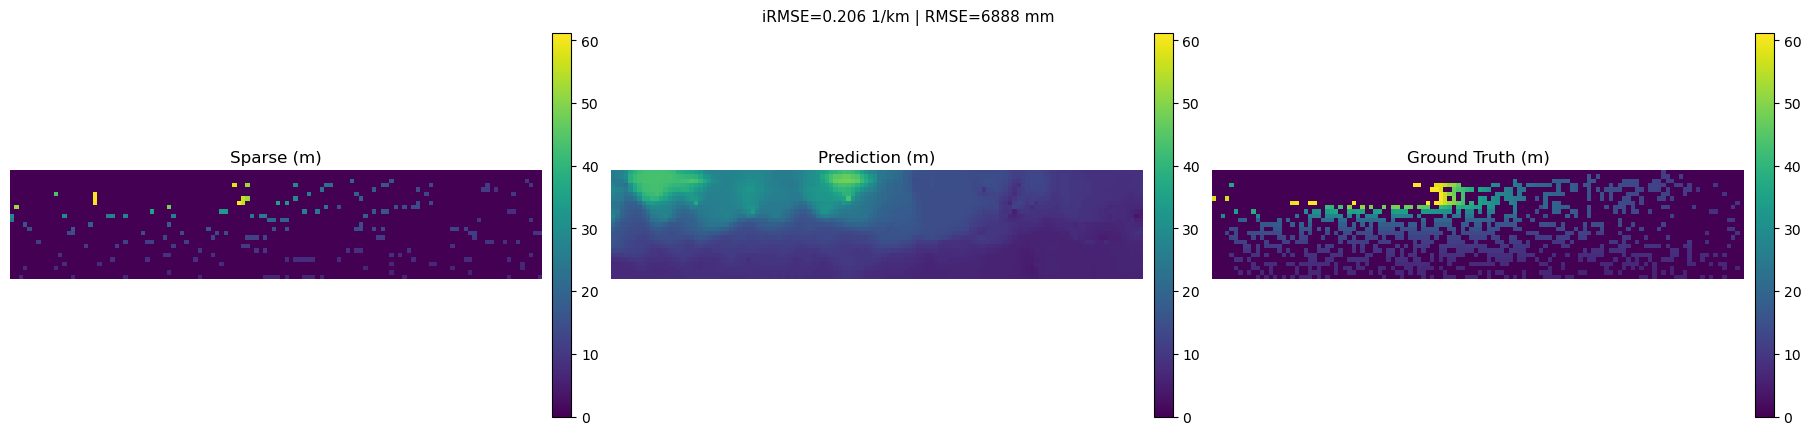

In [87]:
import os, numpy as np, torch, matplotlib.pyplot as plt


def visualize_one_example(model, dataset=None, loader=None, idx=None, device=None,
                          vmax=None, save_dir=None, title_prefix=""):
    """
    Muestra un ejemplo con: sparse, prediccion, ground truth y error absoluto.
    - dataset: objeto Dataset para indexar directamente (recomendado)
    - loader:  DataLoader (si no pasas dataset, toma el primer batch del loader)
    - idx:     indice del ejemplo (si usas dataset). Si None, coge uno aleatorio.
    - vmax:    tope de color para profundidad (m). Si None, usa p99 de los validos.
    - save_dir: si no es None, guarda la figura y el PNG de prediccion (16-bit, *256).
    """
    assert (dataset is not None) or (loader is not None), "Pasa dataset o loader."
    # Use global DEVICE if not provided, else fallback to dynamic check
    if device is None:
        if 'DEVICE' in globals():
             device = DEVICE
        else:
             if torch.cuda.is_available():
                 device = torch.device('cuda')
             elif torch.backends.mps.is_available():
                 device = torch.device('mps')
             else:
                 device = torch.device('cpu')

    model.eval()

    # --- Obten el sample
    if dataset is not None:
        if idx is None:
            idx = np.random.randint(len(dataset))
        sample = dataset[idx]
        sparse = sample["sparse"].unsqueeze(0).to(device).float()  # (1,1,H,W)
        mask   = sample["mask"].unsqueeze(0).to(device).float()
        gt     = sample["gt"].unsqueeze(0).to(device).float()
    else:
        batch = next(iter(loader))
        sparse = batch["sparse"].to(device).float()  # asume batch_size=1
        mask   = batch["mask"].to(device).float()
        gt     = batch["gt"].to(device).float()

    # --- Prediccion
    with torch.no_grad():
        x = torch.cat([sparse, mask], dim=1)  # (B,2,H,W)
        pred = get_depth_prediction(model(x))

    # --- Metricas de ese ejemplo
    mets = kitti_metrics(pred, gt, mask)
    print(f"Metrics > RMSE: {mets['RMSE_mm']:.1f} mm | MAE: {mets['MAE_mm']:.1f} mm | "
          f"iRMSE: {mets['iRMSE_1_per_km']:.3f} 1/km | iMAE: {mets['iMAE_1_per_km']:.3f} 1/km")

    # --- A CPU/NumPy
    sp = sparse[0,0].detach().cpu().numpy()
    pr = pred[0,0].detach().cpu().numpy()
    gt_np = gt[0,0].detach().cpu().numpy()
    mk = (mask[0,0].detach().cpu().numpy() > 0).astype(np.float32)
    err = np.abs(pr - gt_np) * mk

    # --- Rango visual
    if vmax is None:
        valid = gt_np[mk > 0]
        vmax = np.percentile(valid, 99) if valid.size else float(np.max(gt_np) or 1.0)
    emax = np.percentile(err[mk > 0], 99) if (err[mk > 0].size) else 1.0

    # --- Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
    im0 = axs[0].imshow(sp, vmin=0, vmax=vmax); axs[0].set_title("Sparse (m)"); axs[0].axis("off")
    im1 = axs[1].imshow(pr, vmin=0, vmax=vmax); axs[1].set_title("Prediction (m)"); axs[1].axis("off")
    im2 = axs[2].imshow(gt_np, vmin=0, vmax=vmax); axs[2].set_title("Ground Truth (m)"); axs[2].axis("off")
    for ax, im in zip(axs, [im0, im1, im2]):
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

    supt = f"{title_prefix} iRMSE={mets['iRMSE_1_per_km']/100:.3f} 1/km | RMSE={mets['RMSE_mm']:.0f} mm"
    fig.suptitle(supt, y=1.05, fontsize=11)
    plt.show()

    # --- Guardar opcional
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        # figura
        out_fig = os.path.join(save_dir, f"viz_{np.random.randint(1e9):09d}.png")
        fig.savefig(out_fig, dpi=150, bbox_inches="tight")
        print("Saved fig:", out_fig)
        # prediccion como PNG 16-bit (escala KITTI tipica *256)
        pred_png = np.clip(pr * 256.0, 0, 65535).astype(np.uint16)
        out_png = os.path.join(save_dir, "pred_16bit.png")
        import cv2
        cv2.imwrite(out_png, pred_png)


print("Visualizing random validation example...")
visualize_one_example(model, loader=loader_val, device=DEVICE)


Visualizing random validation example...
Metrics > RMSE: 6887.6 mm | MAE: 3504.1 mm | iRMSE: 20.563 1/km | iMAE: 15.036 1/km


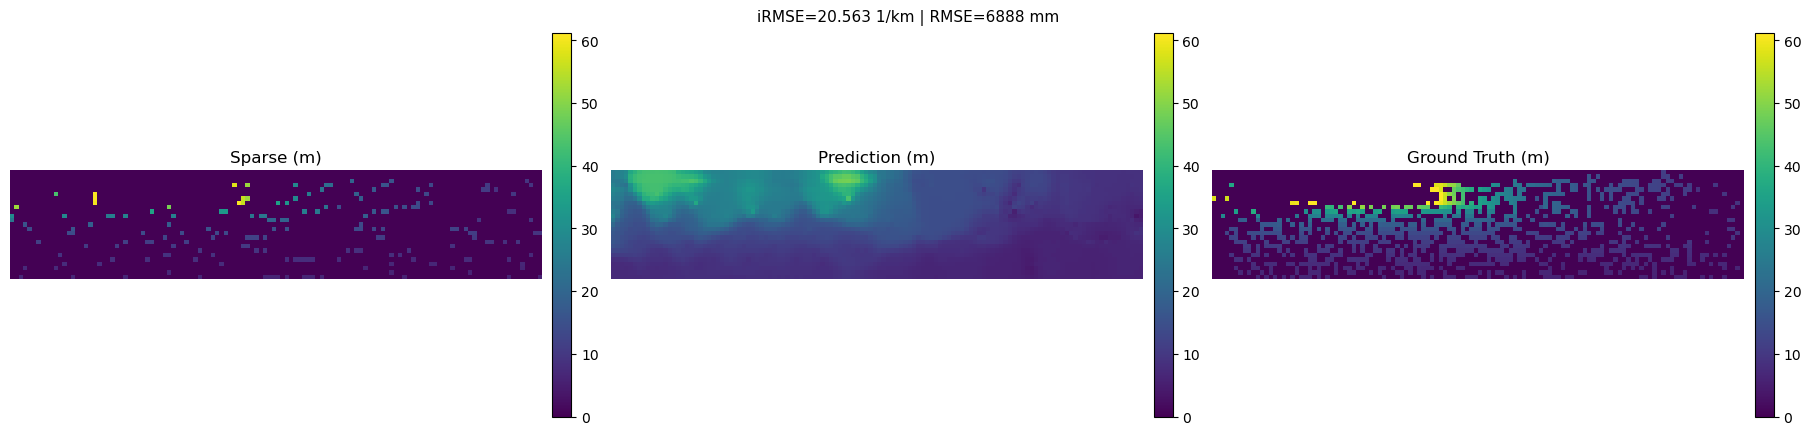

In [73]:
# Visualizar un ejemplo del conjunto de validacion
print("Visualizing random validation example...")
visualize_one_example(model, loader=loader_val, device=DEVICE)
